# DeepAR in Traffic data

<a href="https://colab.research.google.com/github/Nixtla/hierarchicalforecast/blob/main/nbs/examples/AustralianDomesticTourism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In many cases, only the time series at the lowest level of the hierarchies (bottom time series) are available. `HierarchicalForecast` has tools to create time series for all hierarchies. In this notebook we will see how to do it.

In [59]:

# compute base forecast no coherent
from statsforecast.core import StatsForecast
from statsforecast.models import AutoARIMA, Naive
import pandas as pd

#obtain hierarchical reconciliation methods and evaluation
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.methods import BottomUp, TopDown, MiddleOut
from datasetsforecast.hierarchical import HierarchicalData
import numpy as np
from statsforecast.models import ETS


## Aggregate bottom time series

In this example we will use the [Tourism](https://otexts.com/fpp3/tourism.html) dataset from the [Forecasting: Principles and Practice](https://otexts.com/fpp3/) book. The dataset only contains the time series at the lowest level, so we need to create the time series for all hierarchies.

In [60]:
# Load TourismSmall dataset
Y_df, S, tags = HierarchicalData.load('./data', 'Traffic')
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

In [61]:
Y_df

,unique_id,ds,y
0,Total,2008-01-01,1536.0182
1,Total,2008-01-02,1619.2435
2,Total,2008-01-03,1423.6574
3,Total,2008-01-04,1096.3325
4,Total,2008-01-05,974.5526
...,...,...,...
75757,Bottom200,2008-12-27,13.0458
75758,Bottom200,2008-12-28,11.6035
75759,Bottom200,2008-12-29,13.4012
75760,Bottom200,2008-12-30,13.3731


In [62]:
unq_ids = Y_df["unique_id"].unique()
len(unq_ids)

207

In [63]:
len(Y_df[Y_df["unique_id"] == unq_ids[0]])

366

In [64]:
S

,Bottom1,Bottom2,Bottom3,Bottom4,Bottom5,Bottom6,Bottom7,Bottom8,Bottom9,Bottom10,...,Bottom191,Bottom192,Bottom193,Bottom194,Bottom195,Bottom196,Bottom197,Bottom198,Bottom199,Bottom200
Total,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
y1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
y2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
y11,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
y12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Bottom196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Bottom197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Bottom198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Bottom199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [65]:
tags

{'Level1': array(['Total'], dtype=object),
 'Level2': array(['y1', 'y2'], dtype=object),
 'Level3': array(['y11', 'y12', 'y21', 'y22'], dtype=object),
 'Level4': array(['Bottom1', 'Bottom2', 'Bottom3', 'Bottom4', 'Bottom5', 'Bottom6',
        'Bottom7', 'Bottom8', 'Bottom9', 'Bottom10', 'Bottom11',
        'Bottom12', 'Bottom13', 'Bottom14', 'Bottom15', 'Bottom16',
        'Bottom17', 'Bottom18', 'Bottom19', 'Bottom20', 'Bottom21',
        'Bottom22', 'Bottom23', 'Bottom24', 'Bottom25', 'Bottom26',
        'Bottom27', 'Bottom28', 'Bottom29', 'Bottom30', 'Bottom31',
        'Bottom32', 'Bottom33', 'Bottom34', 'Bottom35', 'Bottom36',
        'Bottom37', 'Bottom38', 'Bottom39', 'Bottom40', 'Bottom41',
        'Bottom42', 'Bottom43', 'Bottom44', 'Bottom45', 'Bottom46',
        'Bottom47', 'Bottom48', 'Bottom49', 'Bottom50', 'Bottom51',
        'Bottom52', 'Bottom53', 'Bottom54', 'Bottom55', 'Bottom56',
        'Bottom57', 'Bottom58', 'Bottom59', 'Bottom60', 'Bottom61',
        'Bottom62', 

In [66]:
len(tags.keys())

4

### Split Train/Test sets

We use the final horizon as test set.

In [67]:
HORIZON = 7
FREQUENCY = "1D"

In [68]:
Y_test_df = Y_df.groupby('unique_id').tail(HORIZON)
Y_train_df = Y_df.drop(Y_test_df.index)

In [69]:
Y_train_df = Y_train_df.set_index("unique_id")
Y_test_df = Y_test_df.set_index("unique_id")

In [70]:
Y_test_df

,ds,y
unique_id,,
Total,2008-12-25,1036.8308
Total,2008-12-26,1563.6199
Total,2008-12-27,1606.0017
Total,2008-12-28,1567.3015
Total,2008-12-29,1722.5124
...,...,...
Bottom200,2008-12-27,13.0458
Bottom200,2008-12-28,11.6035
Bottom200,2008-12-29,13.4012


In [71]:
Y_train_df.groupby('unique_id').size()

unique_id
Bottom1      359
Bottom10     359
Bottom100    359
Bottom101    359
Bottom102    359
            ... 
y11          359
y12          359
y2           359
y21          359
y22          359
Length: 207, dtype: int64

## Computing base forecasts

The following cell computes the **base forecasts** for each time series in `Y_df` using the `auto_arima` and `naive` models. Observe that `Y_hat_df` contains the forecasts but they are not coherent.

In [72]:
# Convert train df to gluonts format
# from data_utils import convert_df_to_gluonts_iter

from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName

def convert_df_to_gluonts_iter(df: pd.DataFrame, horizon: int, frequency: str):

    unq_ids = np.unique(df.index)

    all_ts = []
    for id_ in unq_ids:
        df_one_ts = df[df.index == id_].sort_values("ds")
        start_time = df_one_ts["ds"][0]
        target_vals = df_one_ts["y"].values
        # print(id_, start_time, target_vals)
        all_ts.append(
            {
                FieldName.TARGET: target_vals,
                FieldName.START: start_time,
                FieldName.ITEM_ID: id_
            }
        )
    return ListDataset(all_ts, freq=frequency)

gluon_dset_train = convert_df_to_gluonts_iter(Y_train_df, HORIZON, FREQUENCY)
gluon_dset_test = convert_df_to_gluonts_iter(Y_df.set_index('unique_id'), HORIZON, FREQUENCY)

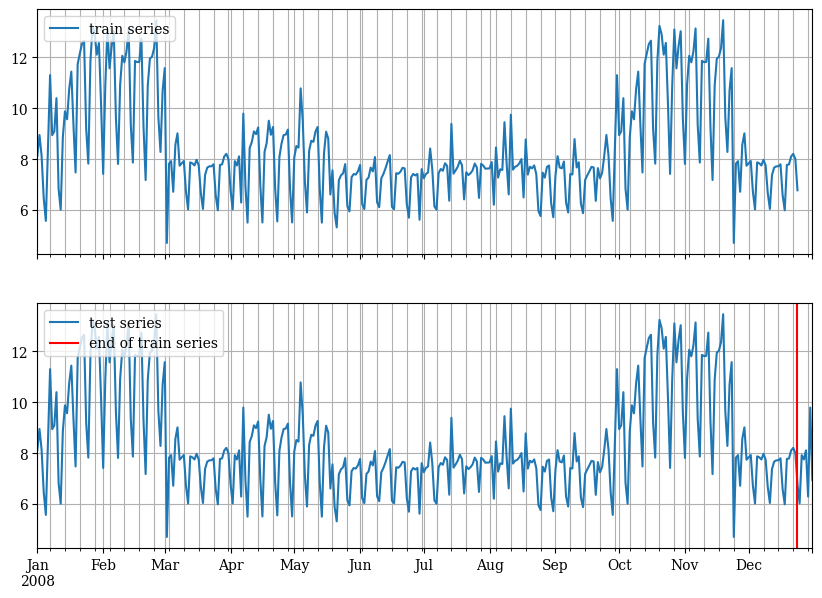

In [73]:
import matplotlib.pyplot as plt
from gluonts.dataset.util import to_pandas

train_entry = next(iter(gluon_dset_train))
test_entry = next(iter(gluon_dset_test))

test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color="r")  # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()



In [74]:

from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer

EPOCHS = 10
FREQ = FREQUENCY
LR = 1e-3
BATCHES_PER_EPOCH = 100

# Get best model params from HPO
CONTEXT_LEN = 4*HORIZON
# num_layers = 2
# dropout_rate = 0.4
# EPOCHS = 25
# num_cells = 40

estimator = DeepAREstimator(
    freq=FREQ,
    prediction_length=HORIZON,
    trainer=Trainer(ctx="cpu", epochs=EPOCHS, learning_rate=1e-3, num_batches_per_epoch=BATCHES_PER_EPOCH),
    context_length=CONTEXT_LEN,
    scaling=True,
    # num_layers=num_layers,
    # num_cells=num_cells, 
    # dropout_rate=dropout_rate
)

predictor = estimator.train(gluon_dset_train)

# # Fit and predict with N-BEATS and N-HiTS models
# models = [NBEATS(input_size=CONTEXT_LEN, h=HORIZON, max_epochs=EPOCHS)]
# fcst = NeuralForecast(models=models, freq='M')
# fcst.fit(df=Y_train_df)

INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:13<00:00,  7.22it/s, epoch=1/10, avg_epoch_loss=2.41]
INFO:gluonts.trainer:Epoch[0] Elapsed time 13.852 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=2.407345
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:13<00:00,  7.40it/s, epoch=2/10, avg_epoch_loss=1.86]
INFO:gluonts.trainer:Epoch[1] Elapsed time 13.518 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=1.864517
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.10it/s, epoch=3/10, avg_epoch_loss=1.75]
INFO:gluonts.trainer:Epoch[2] Elapsed time 12.354 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=1.752156
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.19it/s, epoch=4/10, avg_epoch_loss=1.65]
INFO:gluonts.trainer:Epoch[3] 

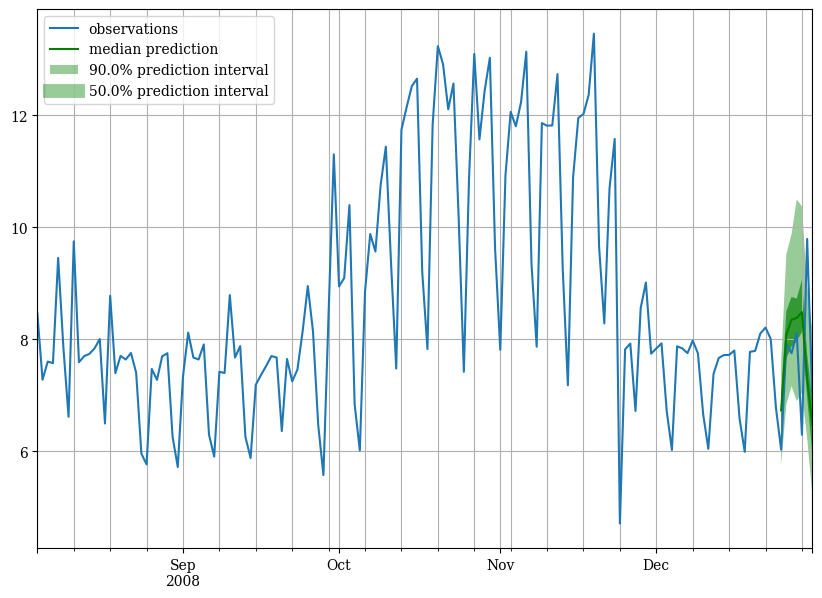

In [75]:
from gluonts.evaluation import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=gluon_dset_test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)


def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [
        f"{k}% prediction interval" for k in prediction_intervals
    ][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color="g")
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()


forecasts = list(forecast_it)
tss = list(ts_it)
ts_entry = tss[0]
forecast_entry = forecasts[0]
plot_prob_forecasts(ts_entry, forecast_entry)

### Convert the forecasts iterator into pandas df

In [76]:
def convert_gluonts_iter_to_df(
    gluon_iter,
    test_dates
):
    out = []
    dates = []
    ids = []
    for x in gluon_iter:
        ids.extend([x.item_id]*HORIZON)
        out.extend(np.mean(x.samples, axis=0).reshape(-1))
        dates.extend(test_dates)
    out = pd.DataFrame({"unique_id": ids, "ds": dates, "y_hat": out})
    out = out.set_index("unique_id")
    return out

test_dates = Y_test_df["ds"].unique()
test_dates.sort()
forecast_df = convert_gluonts_iter_to_df(forecasts, test_dates)
print(forecast_df)

                  ds       y_hat
unique_id                       
Bottom1   2008-12-25    6.745453
Bottom1   2008-12-26    8.085657
Bottom1   2008-12-27    8.423684
Bottom1   2008-12-28    8.529044
Bottom1   2008-12-29    8.596225
...              ...         ...
y22       2008-12-27  399.715942
y22       2008-12-28  389.615631
y22       2008-12-29  401.148407
y22       2008-12-30  350.262817
y22       2008-12-31  259.200867

[1449 rows x 2 columns]


### Computing in-sample forecasts needed for MinT, ERM methods
Note that the model is already trained on the training part of the data. Now, the in-sample forecasts are obtained by a moving window method. These in-sample forecasts are needed to estimate the residual covariance matrix in MinT and ERM methods.

In [77]:
dates = Y_df.ds.unique()
dates.sort()
dates_train = Y_train_df.ds.unique()
dates_train.sort()
Y_hat_in_sample = None
for i in range(0, len(dates_train)-HORIZON-CONTEXT_LEN+1):
    # print(i, i+CONTEXT_LEN, i+CONTEXT_LEN+HORIZON)
    backtest_history = Y_train_df[(Y_train_df.ds >= dates[i]) & (Y_train_df.ds < dates[i+CONTEXT_LEN])]
    end_pt = i+CONTEXT_LEN+HORIZON
    if end_pt < len(dates_train):
        backtest_test_true = Y_train_df[(Y_train_df.ds >= dates[i+CONTEXT_LEN]) & (Y_train_df.ds < dates[end_pt])]
    else:
        backtest_test_true = Y_train_df[(Y_train_df.ds >= dates[i+CONTEXT_LEN])]
    # print(len(backtest_test_true))
    backtest_history_iter = convert_df_to_gluonts_iter(backtest_history, HORIZON, FREQUENCY)
    forecast_it, ts_it = make_evaluation_predictions(
                            dataset=backtest_history_iter,  # test dataset
                            predictor=predictor,  # predictor
                            num_samples=100,  # number of sample paths we want for evaluation
                        )
    forecasts = list(forecast_it)
    # Y_hat_in_sample_part = fcst.predict(df=backtest_history)
    test_dates = backtest_test_true["ds"].unique()
    test_dates.sort()
    Y_hat_in_sample_part = convert_gluonts_iter_to_df(forecasts, test_dates)
    # Y_hat_in_sample_part["ds"] = backtest_test_true["ds"].values
    first_horizon_date = backtest_test_true["ds"].unique()[0]
    if Y_hat_in_sample is None:
        Y_hat_in_sample = Y_hat_in_sample_part[Y_hat_in_sample_part["ds"] == first_horizon_date]
    else:
        if i == len(dates_train)-HORIZON-CONTEXT_LEN:
            Y_hat_in_sample = pd.concat([Y_hat_in_sample, Y_hat_in_sample_part])
        else:
            Y_hat_in_sample = pd.concat([Y_hat_in_sample, Y_hat_in_sample_part[Y_hat_in_sample_part["ds"] == first_horizon_date]])

In [78]:
Y_hat_in_sample_part

,ds,y_hat
unique_id,,
Bottom1,2008-12-18,8.393466
Bottom1,2008-12-19,9.387211
Bottom1,2008-12-20,9.065523
Bottom1,2008-12-21,8.514483
Bottom1,2008-12-22,8.113884
...,...,...
y22,2008-12-20,420.373596
y22,2008-12-21,420.408813
y22,2008-12-22,404.237762


## Predict on test

In [79]:
Y_hat_df = forecast_df
Y_hat_df

,ds,y_hat
unique_id,,
Bottom1,2008-12-25,6.745453
Bottom1,2008-12-26,8.085657
Bottom1,2008-12-27,8.423684
Bottom1,2008-12-28,8.529044
Bottom1,2008-12-29,8.596225
...,...,...
y22,2008-12-27,399.715942
y22,2008-12-28,389.615631
y22,2008-12-29,401.148407


In [80]:
# Create Y_df with y_hat_in_sample
Y_train_df_extended = Y_train_df.merge(Y_hat_in_sample, on=["ds", "unique_id"], how="inner")
Y_train_df_extended

,ds,y,y_hat
unique_id,,,
Total,2008-01-29,1767.3838,1636.463013
Total,2008-01-30,1726.9505,1671.473145
Total,2008-01-31,1292.7822,1659.492065
Total,2008-02-01,1001.0577,1148.640259
Total,2008-02-02,1583.0309,1218.130493
...,...,...,...
Bottom200,2008-12-20,12.8311,13.280221
Bottom200,2008-12-21,12.6597,13.398363
Bottom200,2008-12-22,12.9989,12.517983


## Reconcile forecasts

The following cell makes the previous forecasts coherent using the `HierarchicalReconciliation` class. Since the hierarchy structure is not strict, we can't use methods such as `TopDown` or `MiddleOut`. In this example we use `BottomUp` and `MinTrace`.

In [81]:
from hierarchicalforecast.methods import BottomUp, MinTrace, ERM

reconcilers = [
    BottomUp(),
    MinTrace(method='mint_shrink'),
    MinTrace(method='ols'),
    ERM(method='reg')
]
hrec = HierarchicalReconciliation(reconcilers=reconcilers)
Y_rec_df = hrec.reconcile(Y_hat_df=Y_hat_df, Y_df=Y_train_df_extended, S=S, tags=tags)

The dataframe `Y_rec_df` contains the reconciled forecasts.

In [82]:
Y_rec_df

,ds,y_hat,y_hat/BottomUp,y_hat/MinTrace_method-mint_shrink,y_hat/MinTrace_method-ols,y_hat/ERM_method-reg_lambda_reg-0.01
unique_id,,,,,,
Total,2008-12-25,1174.831665,1214.169800,1181.528836,1181.900429,1121.874023
Total,2008-12-26,1566.100342,1551.704590,1517.003876,1549.202976,1233.469360
Total,2008-12-27,1620.781250,1627.816406,1650.782802,1635.941811,1330.831421
Total,2008-12-28,1606.743286,1608.853516,1606.325580,1609.079846,1333.553711
Total,2008-12-29,1678.973145,1696.815918,1655.989678,1676.742038,1526.773926
...,...,...,...,...,...,...
Bottom200,2008-12-27,12.993835,12.993835,12.974326,12.952276,8.491127
Bottom200,2008-12-28,12.556799,12.556799,12.436937,12.440627,8.648460
Bottom200,2008-12-29,13.113672,13.113672,12.972139,12.849072,10.541286


## Evaluation 

The `HierarchicalForecast` package includes the `HierarchicalEvaluation` class to evaluate the different hierarchies and also is capable of compute scaled metrics compared to a benchmark model.

In [83]:
from hierarchicalforecast.evaluation import HierarchicalEvaluation

def rmse(y, y_hat):
    return np.mean(np.sqrt(np.mean((y-y_hat)**2, axis=1)))

def mase(y, y_hat, y_insample, seasonality=4):
    errors = np.mean(np.abs(y - y_hat), axis=1)
    scale = np.mean(np.abs(y_insample[:, seasonality:] - y_insample[:, :-seasonality]), axis=1)
    return np.mean(errors / scale)

def rmsse(y, y_hat, y_insample):
    errors = np.mean(np.square(y - y_hat), axis=1)
    scale = np.mean(np.square(y_insample[:, 1:] - y_insample[:, :-1]), axis=1)
    return np.mean(np.sqrt(errors / scale))

eval_tags = {}
for k in tags.keys():
    eval_tags[k] = tags[k]

evaluator = HierarchicalEvaluation(evaluators=[rmse, mase, rmsse])
evaluation = evaluator.evaluate(
        Y_hat_df=Y_rec_df, Y_test_df=Y_test_df,
        tags=eval_tags, Y_df=Y_train_df
)
evaluation = evaluation.drop('Overall')
# evaluation.columns = ['Base', 'BottomUp', 'MinTrace(mint_shrink)', 'MinTrace(ols)']
evaluation.columns = ['Base', 'BottomUp', 'MinTrace(ols)', 'MinTrace(mint_shrink)', 'ERM']
evaluation = evaluation.applymap('{:.4f}'.format)

/tmp/ipykernel_2890276/3617059200.py:25: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  evaluation = evaluation.drop('Overall')


### RMSE

The following table shows the performance measured using RMSE across levels for each reconciliation method.

In [84]:
score_df = evaluation.query('metric == "rmse"')
score_df

,,Base,BottomUp,MinTrace(ols),MinTrace(mint_shrink),ERM
level,metric,,,,,
Level1,rmse,187.1679,157.3853,183.6047,181.8835,298.6499
Level2,rmse,89.1277,78.8024,91.8306,91.1471,150.3391
Level3,rmse,46.1796,41.3634,47.4967,47.6987,75.9689
Level4,rmse,1.9262,1.9262,1.9883,1.9774,2.3702


### MASE


The following table shows the performance measured using MASE across levels for each reconciliation method.

In [85]:
evaluation.query('metric == "mase"')

,,Base,BottomUp,MinTrace(ols),MinTrace(mint_shrink),ERM
level,metric,,,,,
Level1,mase,0.3849,0.3397,0.4159,0.3900,0.8183
Level2,mase,0.3970,0.3413,0.4173,0.3914,0.8175
Level3,mase,0.4296,0.3740,0.4341,0.4353,0.8162
Level4,mase,0.6925,0.6925,0.7078,0.7076,0.9343


### RMSSE

In [86]:
score_df = evaluation.query('metric == "rmsse"')
score_df

,,Base,BottomUp,MinTrace(ols),MinTrace(mint_shrink),ERM
level,metric,,,,,
Level1,rmsse,0.6952,0.5846,0.6820,0.6756,1.1093
Level2,rmsse,0.6601,0.5841,0.6804,0.6752,1.1098
Level3,rmsse,0.6815,0.6104,0.7006,0.7028,1.1136
Level4,rmsse,0.9719,0.9719,1.0028,1.0002,1.1962


In [87]:
score_df.astype(float).mean()

Base                     0.752175
BottomUp                 0.687750
MinTrace(ols)            0.766450
MinTrace(mint_shrink)    0.763450
ERM                      1.132225
dtype: float64

### Comparison fable

Observe that we can recover the results reported by the [Forecasting: Principles and Practice](https://otexts.com/fpp3/tourism.html). The original results were calculated using the R package [fable](https://github.com/tidyverts/fable).

![Fable's reconciliation results](./imgs/AustralianDomesticTourism-results-fable.png)

### References
- [Hyndman, R.J., & Athanasopoulos, G. (2021). "Forecasting: principles and practice, 3rd edition: 
Chapter 11: Forecasting hierarchical and grouped series.". OTexts: Melbourne, Australia. OTexts.com/fpp3 
Accessed on July 2022.](https://otexts.com/fpp3/hierarchical.html)
- [Rob Hyndman, Alan Lee, Earo Wang, Shanika Wickramasuriya, and Maintainer Earo Wang (2021). "hts: Hierarchical and Grouped Time Series". URL https://CRAN.R-project.org/package=hts. R package version 0.3.1.](https://cran.r-project.org/web/packages/hts/index.html)
- [Mitchell O’Hara-Wild, Rob Hyndman, Earo Wang, Gabriel Caceres, Tim-Gunnar Hensel, and Timothy Hyndman (2021). "fable: Forecasting Models for Tidy Time Series". URL https://CRAN.R-project.org/package=fable. R package version 6.0.2.](https://CRAN.R-project.org/package=fable)